# Analyze names of cookies categories

In [1]:
from collections import defaultdict, Counter
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


from consent.consistency.util import FIG_DIR, get_scan_dirs, get_scan_root_dir
from consent.data.pref_menu_scan.cookie_decl_reader import read_cookie_decls_in_scans

location = 'ie'
SCAN_DIRS = get_scan_dirs('ie')
SCAN_ROOT_DIR = get_scan_root_dir('ie')
output_suffix = '_' + '0k_20k'

In [2]:
# unused, read category names from cookie declarations directly. # prefs, errors, warnings = read_logs_in_scans(data_dirs)

In [3]:
# cookie_decls = read_cookie_decls_in_scans(SCAN_DIRS)
# print(f"Num cookie declarations: {len(cookie_decls):,d}")
# cookie_decls.head()
cookie_decls_file = SCAN_ROOT_DIR / f'cookie_decls{output_suffix}.parquet'
raw_cookie_decls = pd.read_parquet(cookie_decls_file)
# raw_cookie_decls = read_cookie_decls_in_scans(SCAN_DIRS)
print(f"Num cookie declarations: {len(raw_cookie_decls):,d}")
raw_cookie_decls.head()

Num cookie declarations: 282,716


,name,domain,duration,category_id,category,consent_mode,site,lib_name,pattern_name
index,,,,,,,,,
0,__we_bucket_id,www.wework.com,365 days,C0001,Strictly Necessary Cookies,always active,wework.com,onetrust,en.json
1,s_xxxx,wework.com,730 days,C0001,Strictly Necessary Cookies,always active,wework.com,onetrust,en.json
2,ajs_anonymous_id,wework.com,365 days,C0001,Strictly Necessary Cookies,always active,wework.com,onetrust,en.json
3,OptanonConsent,www.wework.com,365 days,C0001,Strictly Necessary Cookies,always active,wework.com,onetrust,en.json
4,__we_request_id,www.wework.com,Session,C0001,Strictly Necessary Cookies,always active,wework.com,onetrust,en.json


In [4]:
# out_dir = create_data_dir('2022-01-14')
# out_file = out_dir / 'cookie_decls.parquet'
# cookie_decls.to_parquet(out_file); print(f"Written to {out_file}")

## How many categories?

In [5]:
from consent.consistency.util import normalize_cookie_category_name
import sys; import importlib; importlib.reload(sys.modules['consent.consistency.util'])
from consent.consistency.util import normalize_cookie_category_name

cookie_decls = raw_cookie_decls
cookie_decls['norm_name'] = cookie_decls['category'].map(normalize_cookie_category_name)
cookie_decls

,name,domain,duration,category_id,category,consent_mode,site,lib_name,pattern_name,norm_name
index,,,,,,,,,,
0,__we_bucket_id,www.wework.com,365 days,C0001,Strictly Necessary Cookies,always active,wework.com,onetrust,en.json,Necessary
1,s_xxxx,wework.com,730 days,C0001,Strictly Necessary Cookies,always active,wework.com,onetrust,en.json,Necessary
2,ajs_anonymous_id,wework.com,365 days,C0001,Strictly Necessary Cookies,always active,wework.com,onetrust,en.json,Necessary
3,OptanonConsent,www.wework.com,365 days,C0001,Strictly Necessary Cookies,always active,wework.com,onetrust,en.json,Necessary
4,__we_request_id,www.wework.com,Session,C0001,Strictly Necessary Cookies,always active,wework.com,onetrust,en.json,Necessary
...,...,...,...,...,...,...,...,...,...,...
40,player,vimeo.com,364 days,C0003,Functional Cookies,inactive,pixabay.com,onetrust,en.json,Functional
41,vuid,vimeo.com,729 days,C0003,Functional Cookies,inactive,pixabay.com,onetrust,en.json,Functional
42,_GRECAPTCHA,www.recaptcha.net,179 days,C0003,Functional Cookies,inactive,pixabay.com,onetrust,en.json,Functional


In [6]:
site_cats = cookie_decls[['site', 'category', 'norm_name']].drop_duplicates()
site_cats.norm_name.value_counts()[:50]

Advertising                                         1450
Necessary                                           1392
Functional                                          1121
Performance                                         1084
Social Media                                         214
Statistics                                           118
Analytics                                            111
Unclassified                                          99
Preferences                                           85
Functionality                                         31
Ussupport                                             17
Opt-Out Form                                          17
Personalization                                       16
Necessary and Site Functionality                      16
Personalization (Content Selection and Delivery)      16
Performance & Analytics                               14
Performance and Analytics                             13
Analytical                     

In [7]:
# scans[scans.norm_name.str.contains('Sale')]

In [8]:
cat_to_count = Counter()
necessary_domains = set()
domain_to_ncats = {}
non_necessary_domains = []

for domain, group in site_cats.groupby('site'):
    domain_categories = group.norm_name.tolist()
    cat_to_count.update(domain_categories)
    # if not any(nec in cat for nec in ['Necessary', 'Required', 'Essential', 'Core'] for cat in domain_categories):
    if all('Strictly Necessary' != cat for cat in domain_categories):
#         print(domain_categories)
        non_necessary_domains.append(domain)
    else:
        necessary_domains.add(domain)
    domain_to_ncats[domain] = len(domain_categories)

print(f"Num cat names: {len(cat_to_count)}")
print(f"{len(non_necessary_domains)=} {len(necessary_domains)=}")
# print(f"{non_necessary_domains=}")
cat_to_count.most_common(3)

Num cat names: 194
len(non_necessary_domains)=1463 len(necessary_domains)=0


[('Advertising', 1450), ('Necessary', 1392), ('Functional', 1121)]

In [9]:
# Number of categories per site
ncats = list(domain_to_ncats.values())
print(f"Number of categories per domain: {np.mean(ncats):.2f} ({np.std(ncats):.2f} SD) min: {np.min(ncats)} max: {np.max(ncats)}")

Number of categories per domain: 4.22 (0.94 SD) min: 1 max: 19


In [10]:
domain_to_ncats_df = pd.DataFrame(list(domain_to_ncats.items()),columns=['domain','ncats'])
# ax = sns.barplot(x='domain', y='ncats', data=domain_to_ncats_df); ticks = plt.xticks(rotation=45, ha='right')
print("Num sites with 1 category:", len(domain_to_ncats_df[domain_to_ncats_df.ncats == 1]))
# assert len(domain_to_ncats_df[domain_to_ncats_df.ncats == 1]) == 0, "There should not be any site with only 1 category"
# print(domain_to_ncats_df[domain_to_ncats_df.ncats == 2].domain.tolist())

Num sites with 1 category: 5


In [11]:
cat_names = site_cats['norm_name'].value_counts()
cat_names = cat_names.to_frame().reset_index().sort_values(by=['norm_name', 'index'], ascending=[False, True])
# n_sites = site_cats.site.nunique()
n_sites = 1355 # TODO: how to automate this
cat_names['norm_name_percent'] = cat_names['norm_name'] / n_sites * 100
cat_names['num_sites'] = cat_names.apply(lambda row: f"{row['norm_name_percent']:.2f}% ({row['norm_name']}/{n_sites})", axis=1)
# cat_names

In [12]:
print(f"Number of category names: {len(cat_names)}")
print(f"Number of category with only 1 occurrence: {len(cat_names[cat_names.norm_name == 1])}")

Number of category names: 194
Number of category with only 1 occurrence: 118


In [13]:
latex = cat_names.head(10)[['index', 'num_sites']]
latex = latex.rename(columns={'index': 'Cookie Category', 'num_sites': '# Websites'})
latex.index = range(1, len(latex)+1)
print(latex.to_latex(index=True))

\begin{tabular}{lll}
\toprule
{} & Cookie Category &           \# Websites \\
\midrule
1  &     Advertising &  107.01\% (1450/1355) \\
2  &       Necessary &  102.73\% (1392/1355) \\
3  &      Functional &   82.73\% (1121/1355) \\
4  &     Performance &   80.00\% (1084/1355) \\
5  &    Social Media &    15.79\% (214/1355) \\
6  &      Statistics &     8.71\% (118/1355) \\
7  &       Analytics &     8.19\% (111/1355) \\
8  &    Unclassified &      7.31\% (99/1355) \\
9  &     Preferences &      6.27\% (85/1355) \\
10 &   Functionality &      2.29\% (31/1355) \\
\bottomrule
\end{tabular}



/tmp/ipykernel_4066191/3667371263.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(latex.to_latex(index=True))


Written to /home/ducbui/local_projects/consent/paper/consentchk_v2/Figures/cookie_category.pdf


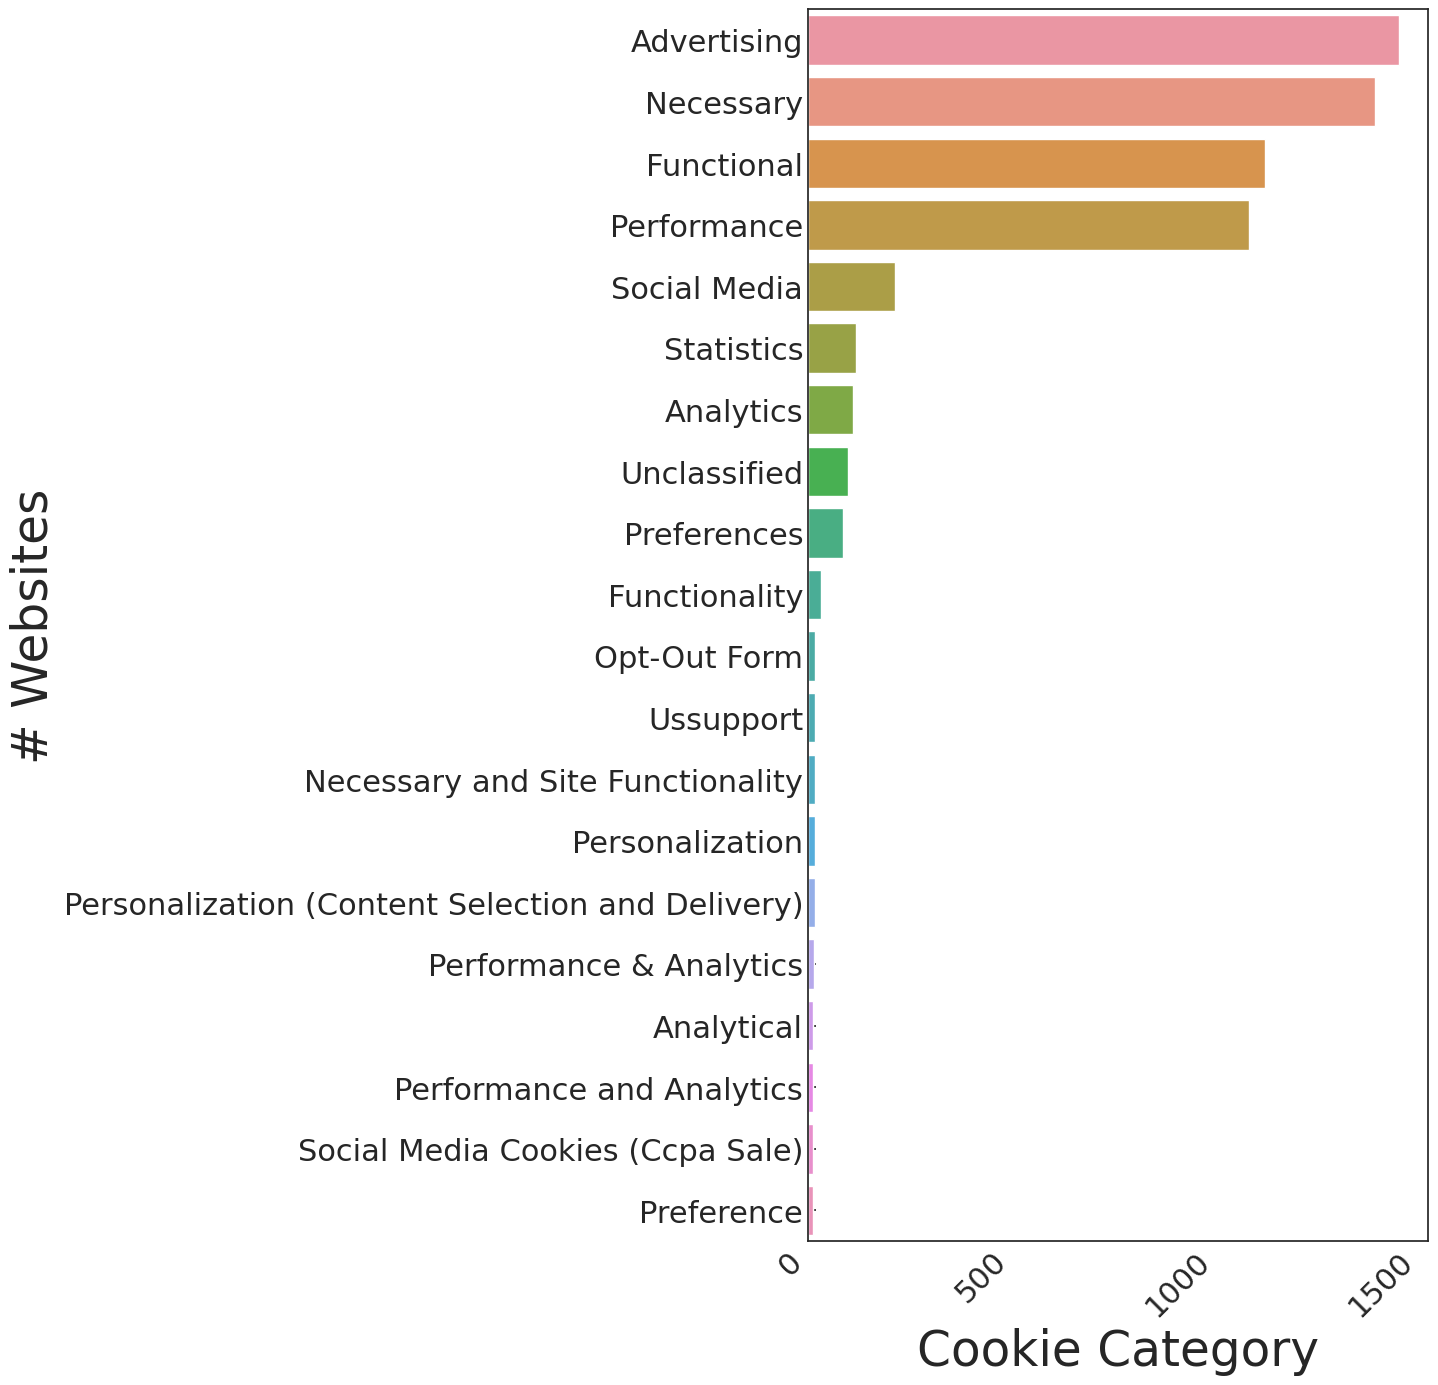

In [24]:
sns.set(rc={'figure.figsize':(8,16),"font.size":25,"axes.titlesize":25,"axes.labelsize":35},style="white", font_scale = 2)

common_cat_names = cat_names.iloc[:20]
ax = sns.barplot(y=common_cat_names['index'], x=common_cat_names.norm_name)
ticks = plt.xticks(rotation=45, ha='right')

ax.tick_params(left=True, bottom=False, direction="in")
ax.set_ylabel('# Websites')
ax.set_xlabel('Cookie Category')

out_file = FIG_DIR / 'cookie_category.pdf'; plt.savefig(out_file, dpi=200, bbox_inches='tight'); print(f"Written to {out_file}")

# Number of cookies per category (See ncookie_per_category notebook)

In [15]:
n_cookies_per_cat = cookie_decls.groupby('norm_name').size().sort_values(ascending=False)
assert n_cookies_per_cat.sum() == len(cookie_decls)
n_cookies_per_cat[:10]

norm_name
Advertising      127730
Necessary         50259
Performance       39207
Functional        29233
Unclassified       8114
Statistics         7897
Preferences        3343
Analytics          3076
Social Media       1230
Functionality      1139
dtype: int64

In [16]:
n_cookies_per_cat = n_cookies_per_cat / n_cookies_per_cat.sum() * 100
n_cookies_per_cat[:10]

norm_name
Advertising      45.179615
Necessary        17.777204
Performance      13.867981
Functional       10.340059
Unclassified      2.870018
Statistics        2.793262
Preferences       1.182459
Analytics         1.088018
Social Media      0.435066
Functionality     0.402878
dtype: float64

# Below copied to cookie_declaration_notebook.ipynb

## How many cookies per site?

In [17]:
from consent.data.site_pref import read_site_prefs

In [18]:
scanned_sites = [site_dir.name for site_dir in data_dir.glob('*') if site_dir.is_dir()]
site_dirs = [data_dir / site for site in scanned_sites]
print("Number of scanned sites:", len(scanned_sites)) # , scanned_sites)
site_prefs = read_site_prefs(site_dirs)
site_prefs

NameError: name 'data_dir' is not defined

In [ ]:
cookielist_sites = sorted(site_prefs.site.unique().tolist())
n_cookielist_sites = len(cookielist_sites)
assert site_prefs.site.nunique() == n_cookielist_sites
print("Sites with cookie list:", n_cookielist_sites, cookielist_sites)

Sites with cookie list: 83 ['accorhotels.com', 'adtelligent.com', 'apachefriends.org', 'behance.net', 'bestwestern.com', 'biomedcentral.com', 'bitnami.com', 'bodybuilding.com', 'britishcouncil.org', 'callofduty.com', 'canon.com', 'cell.com', 'chanel.com', 'christies.com', 'cloudflare.com', 'cnet.com', 'commonsensemedia.org', 'corel.com', 'digicert.com', 'digitalspy.com', 'documentforce.com', 'download.com', 'elsevier.com', 'elsevierhealth.com', 'exacttarget.com', 'exoclick.com', 'fairmont.com', 'fendi.com', 'force.com', 'gamespot.com', 'glassdoor.co.in', 'glassdoor.com', 'goal.com', 'healthgrades.com', 'home.kpmg', 'hotjar.com', 'irishtimes.com', 'kpmg.com', 'magento.com', 'mango.com', 'marketo.com', 'mcdonalds.com', 'media.net', 'mendeley.com', 'metacritic.com', 'myportfolio.com', 'nature.com', 'netflix.com', 'news24.com', 'nflxvideo.net', 'oclc.org', 'onetrust.com', 'pardot.com', 'payoneer.com', 'pendo.io', 'rapidssl.com', 'redbull.com', 'rte.ie', 'salesforce.com', 'scientificamerica

In [ ]:
def get_cat_name(site, group_id):
    found = scans[ (scans.domain == site) & (scans['id'] == group_id)]
    assert len(found) == 1
    return found.iloc[0]['norm_name']
site_prefs['norm_name'] = site_prefs.apply(lambda row: get_cat_name(row['site'], row['group_id']), axis=1)
site_prefs

,duration,host,name,group_id,site,consent,norm_name
0,Session,healthgrades.com,_vapi,C0001,healthgrades.com,True,Strictly Necessary
1,365 days,partners.healthgrades.com,OptanonConsent,C0001,healthgrades.com,True,Strictly Necessary
2,a few seconds,healthgrades.com,_dc_gtm_UA-xxxxxxxx,C0001,healthgrades.com,True,Strictly Necessary
3,2914169 days,partners.healthgrades.com,eupubconsent,C0001,healthgrades.com,True,Strictly Necessary
4,365 days,healthgrades.com,OptanonAlertBoxClosed,C0001,healthgrades.com,True,Strictly Necessary
...,...,...,...,...,...,...,...
12932,390 days,yieldoptimizer.com,ph,SPD_BG,bestwestern.com,False,Other Third Party
12933,390 days,yieldoptimizer.com,dph,SPD_BG,bestwestern.com,False,Other Third Party
12934,390 days,yieldoptimizer.com,gcma,SPD_BG,bestwestern.com,False,Other Third Party
12935,390 days,yieldoptimizer.com,ckid,SPD_BG,bestwestern.com,False,Other Third Party


In [ ]:
site_prefs[ (site_prefs.site == 'fendi.com') ]

,duration,host,name,group_id,site,consent,norm_name
499,Session,www.fendi.com,JSESSIONID,C0001,fendi.com,True,Strictly Necessary
500,a few seconds,fendi.com,_dc_gtm_UA-xxxxxxxx,C0001,fendi.com,True,Strictly Necessary
501,Session,www.fendi.com,AWSELB,C0001,fendi.com,True,Strictly Necessary
502,365 days,fendi.com,OptanonConsent,C0001,fendi.com,True,Strictly Necessary
503,3000 days,www.fendi.com,f_nl_count,C0001,fendi.com,True,Strictly Necessary
...,...,...,...,...,...,...,...
572,397 days,addthis.com,xtc,C0004,fendi.com,False,Targeting
573,730 days,atdmt.com,ATN,C0004,fendi.com,False,Targeting
574,Session,youtube.com,YSC,C0004,fendi.com,False,Targeting
575,180 days,youtube.com,VISITOR_INFO1_LIVE,C0004,fendi.com,False,Targeting


In [ ]:
def get_num_cookies(site, norm_name):
    group = site_prefs[ (site_prefs.site == site) & (site_prefs.norm_name == norm_name) ][['host', 'name']]
    if len(group) != len(group.drop_duplicates()):
        print(f'WARNING: there should be no duplicate per category {site=}')
        print(group)
    return len(group.drop_duplicates())

site_ncookies_data = defaultdict(list)
for site in site_prefs.site.unique():
    site_ncookies_data['site'].append(site)
    for norm_name in site_prefs.norm_name.unique():
        site_ncookies_data[norm_name].append(get_num_cookies(site, norm_name))
    site_ncookies_data['all_cookies'].append(len(site_prefs[ (site_prefs.site == site) ]))
site_ncookies = pd.DataFrame(site_ncookies_data)
site_ncookies
# name_to_ncookies = {norm_name: get_num_cookies(norm_name) for norm_name in site_prefs.norm_name.unique()}

                 host                name
552         fendi.com                _fbp
553     www.fendi.com       _cs_same_site
554         fendi.com     _cs_root-domain
555         fendi.com             _uetsid
556         fendi.com               _scid
557         yahoo.com                  A3
558         yahoo.com                   B
559         yahoo.com                   B
560          bing.com                MUID
561          turn.com                 uid
562        google.com                 NID
563      facebook.com                  fr
564  www.facebook.com                    
565  flashtalking.com     flashtalkingad1
566    s7.addthis.com             __atuvs
567    s7.addthis.com             __atuvc
568   doubleclick.net                 IDE
569   doubleclick.net         test_cookie
570       addthis.com                 loc
571       addthis.com                 uvc
572       addthis.com                 xtc
573         atdmt.com                 ATN
574       youtube.com             

,site,Strictly Necessary,Performance,Functional,Targeting,Necessary,Performance (Or Analytics),Functionality,Advertising,Social Media,...,Personalization,Statistics,Communications,Optional,Analytics/Performance,Marketing & Targeting,Strictly Necessary & Analytics,Social Media and Advertising,Other Third Party,all_cookies
0,healthgrades.com,12,51,11,98,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,172
1,callofduty.com,0,0,0,0,16,14,6,53,0,...,0,0,0,0,0,0,0,0,0,89
2,britishcouncil.org,33,37,27,141,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,238
3,fendi.com,11,36,6,24,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,78
4,gamespot.com,9,24,5,117,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,tvguide.com,8,23,9,167,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,208
79,statista.com,0,6,7,30,55,0,0,0,0,...,0,0,0,0,0,0,0,0,0,98
80,chanel.com,52,18,13,57,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,140
81,bitnami.com,6,10,0,0,0,0,0,16,2,...,0,0,0,0,0,0,0,0,0,34


In [ ]:
site_ncookies.sort_values('all_cookies')

,site,Strictly Necessary,Performance,Functional,Targeting,Necessary,Performance (Or Analytics),Functionality,Advertising,Social Media,...,Personalization,Statistics,Communications,Optional,Analytics/Performance,Marketing & Targeting,Strictly Necessary & Analytics,Social Media and Advertising,Other Third Party,all_cookies
31,exoclick.com,4,0,0,0,0,0,0,4,0,...,0,0,0,0,0,0,0,0,0,11
46,apachefriends.org,2,7,0,0,0,0,0,6,0,...,0,0,0,0,0,0,0,0,0,15
41,warnerbros.com,11,4,1,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,20
63,biomedcentral.com,4,9,1,3,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,30
57,springerlink.com,7,3,3,3,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,unity3d.com,50,64,48,256,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,418
10,unity.com,50,64,48,256,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,418
59,corel.com,19,22,11,448,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,500
7,magento.com,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,530


In [ ]:
mean_site_cookies = site_ncookies.mean().sort_values(ascending=False).head(8)
mean_site_cookies

all_cookies                155.746988
Targeting                   52.325301
Performance                 17.204819
Strictly Necessary          16.951807
Functional                  15.373494
Advertising                 12.373494
Personalize Advertising     10.867470
Measure Performance          5.060241
dtype: float64

In [ ]:
top_cats = mean_site_cookies.index.tolist()
# top_cats = cat_names.head(6)['index'].tolist()
site_ncookies[top_cats]

,all_cookies,Targeting,Performance,Strictly Necessary,Functional,Advertising,Personalize Advertising,Measure Performance
0,172,98,51,12,11,0,0,0
1,89,0,0,0,0,53,0,0
2,238,141,37,33,27,0,0,0
3,78,24,36,11,6,0,0,0
4,155,117,24,9,5,0,0,0
...,...,...,...,...,...,...,...,...
78,208,167,23,8,9,0,0,0
79,98,30,6,0,7,0,0,0
80,140,57,18,52,13,0,0,0
81,34,0,10,6,0,16,0,0


In [ ]:
std_site_cookies = site_ncookies.std()
max_site_cookies = site_ncookies.max()
min_site_cookies = site_ncookies.min()
mean_site_cookies_data = defaultdict(list)
for cat in top_cats:
    mean_site_cookies_data['cat'].append(cat)
    mean_site_cookies_data['mean'].append(site_ncookies[cat].mean())
    mean_site_cookies_data['std'].append(site_ncookies[cat].std())
    mean_site_cookies_data['min'].append(site_ncookies[cat].min())
    mean_site_cookies_data['max'].append(site_ncookies[cat].max())
pd.DataFrame(mean_site_cookies_data)

,cat,mean,std,min,max
0,all_cookies,155.746988,133.582243,11,643
1,Targeting,52.325301,81.315271,0,448
2,Performance,17.204819,20.285619,0,99
3,Strictly Necessary,16.951807,22.536639,0,147
4,Functional,15.373494,30.475784,0,150
5,Advertising,12.373494,44.990164,0,338
6,Personalize Advertising,10.867470,48.983514,0,351
7,Measure Performance,5.060241,21.277120,0,115


In [ ]:
print(f"Number of cookies in cookie lists: {len(site_prefs):,d}")

Number of cookies in cookie lists: 12,927


In [ ]:
def get_unresolved_hosts():
    unresolved_hosts = Counter()
    for _, row in site_prefs.iterrows():
        try:
            resolve_host_declaration(row, row['site'])
        except ValueError:
            unresolved_hosts[row['host']] += 1
    return unresolved_hosts
# unresolved_hosts = get_unresolved_hosts()
n_unresolves = sum(unresolved_hosts.values())
n_decls = len(site_prefs)
print(f"Number of resolved host in cookie declaration: {(1 - n_unresolves / n_decls) * 100}%")
print(f"Number of unresolved host in cookie declaration: {n_unresolves}")
unresolved_hosts

NameError: name 'unresolved_hosts' is not defined

## Analysis of Contradictory Preferences

In [ ]:
# Get information of each categories: group id, editable, set of cookies (name, host)

def find_cookies(site, cat_info):
    """Return a set of tuples (name, host)."""
    found = site_prefs[ (site_prefs.site == site) & (site_prefs['group_id'] == cat_info['group_id']) ]
    return set((cookie['name'], cookie['host']) for _, cookie in found.iterrows())

def get_cat_infos(site, categories, verbose=0):
    for category in categories:
        if verbose >= 2: print(f"{category=}")
        prev_status = category['prev_status']
        cur_status = category['cur_status']
        if prev_status in ['unavailable', 'always_active']:
            assert cur_status == prev_status
            editable = False
        else:
            editable = True
        cat_info = {'editable': editable, 'group_id': category['id'], 'name': category['name']}
        cat_info['cookies'] = find_cookies(site, cat_info)
        yield cat_info

def find_contra_cookies(cat_info1, cat_info2):
    return list(cat_info1['cookies'].intersection(cat_info2['cookies']))

def find_contras(cat_infos, verbose=0):
    contras = []
    for i in range(len(cat_infos) - 1):
        for j in range(i + 1, len(cat_infos)):
            cat_info_i, cat_info_j = cat_infos[i], cat_infos[j]
            if cat_info_i['editable'] or cat_info_j['editable']:
                contra_cookies = find_contra_cookies(cat_info_i, cat_info_j)
                if len(contra_cookies) > 0:
                    if verbose >= 2: print(cat_info_i['name'], cat_info_j['name'], contra_cookies)
                    contras.append({'cat1': cat_info_i['name'], 'cat2': cat_info_j['name'], 'contras': contra_cookies})
    return contras

def get_scan_info(site):
    found = raw_scans[site == raw_scans.domain]
    assert len(found) == 1
    return found.iloc[0].to_dict()

def get_contras(verbose=0):
    found_contras = []
    for site in site_prefs.site.unique():
        # if site != 'vmware.com':            continue
        scan_info = get_scan_info(site)
        cat_infos = list(get_cat_infos(site, scan_info['category']))
        contras = find_contras(cat_infos)
        if len(contras) > 0:
            if verbose >= 2: print(site)
            for contra in contras:
                contra['site'] = site
                found_contras.append(contra)
    return pd.DataFrame(found_contras)

contra_sites = get_contras()
contra_sites = contra_sites.explode('contras').reset_index(drop=True)
contra_sites['contra_name'] = contra_sites.contras.map(lambda contra: contra[0])
contra_sites['contra_host'] = contra_sites.contras.map(lambda contra: contra[1])
contra_sites['contra_cats'] = contra_sites.apply(lambda row: f"{normalize_name(row['cat1'])}-{normalize_name(row['cat2'])}", axis=1)
contra_sites


,cat1,cat2,contras,site,contra_name,contra_host,contra_cats
0,Strictly Necessary,Advertising,"(AWSALBCORS, communities.vmware.com)",vmware.com,AWSALBCORS,communities.vmware.com,Strictly Necessary-Advertising
1,Strictly Necessary,Advertising,"(VISITOR_BEACON, communities.vmware.com)",vmware.com,VISITOR_BEACON,communities.vmware.com,Strictly Necessary-Advertising
2,Performance,Functional,"(AMCVS_5B29123F5245AD520A490D45%40AdobeOrg, vm...",vmware.com,AMCVS_5B29123F5245AD520A490D45%40AdobeOrg,vmware.com,Performance-Functional
3,Performance,Functional,"(AMCV_5B29123F5245AD520A490D45%40AdobeOrg, vmw...",vmware.com,AMCV_5B29123F5245AD520A490D45%40AdobeOrg,vmware.com,Performance-Functional
4,Performance,Advertising,"(test, vmware.com)",vmware.com,test,vmware.com,Performance-Advertising
...,...,...,...,...,...,...,...
134,Performance Cookies,Targeting Cookies,"(_gtld, elsevier.com)",elsevier.com,_gtld,elsevier.com,Performance-Targeting
135,Targeting Cookies,Optional Cookies,"(B, yahoo.com)",glassdoor.co.in,B,yahoo.com,Targeting-Optional
136,Functional Cookies,Advertising Cookies,"(language, www.slideshare.net)",pardot.com,language,www.slideshare.net,Functional-Advertising
137,Functional Cookies,Advertising Cookies,"(lpv1, pi.pardot.com)",pardot.com,lpv1,pi.pardot.com,Functional-Advertising


In [ ]:
contra_cookies = contra_sites[['site', 'cat1', 'contra_name', 'contra_host']].drop_duplicates()
contra_cookies

,site,cat1,contra_name,contra_host
0,vmware.com,Strictly Necessary,AWSALBCORS,communities.vmware.com
1,vmware.com,Strictly Necessary,VISITOR_BEACON,communities.vmware.com
2,vmware.com,Performance,AMCVS_5B29123F5245AD520A490D45%40AdobeOrg,vmware.com
3,vmware.com,Performance,AMCV_5B29123F5245AD520A490D45%40AdobeOrg,vmware.com
4,vmware.com,Performance,test,vmware.com
...,...,...,...,...
134,elsevier.com,Performance Cookies,_gtld,elsevier.com
135,glassdoor.co.in,Targeting Cookies,B,yahoo.com
136,pardot.com,Functional Cookies,language,www.slideshare.net
137,pardot.com,Functional Cookies,lpv1,pi.pardot.com


In [ ]:
print(f"Number of contra prefs: {len(contra_cookies)}, on {contra_cookies.site.nunique()} websites.")

Number of contra prefs: 78, on 22 websites.


In [ ]:
print("Most common category pairs")
contra_sites.contra_cats.value_counts()

Most common category pairs


Strictly Necessary-Targeting                                  13
Performance-Targeting                                         13
Targeting-Social Media                                        11
Performance-Social Media                                      11
Strictly Necessary-Social Media                               10
Strictly Necessary-Performance                                10
Functional-Social Media                                       10
Functional-Targeting                                          10
Functional-Performance                                        10
Strictly Necessary-Functional                                 10
Targeting-Targeting (3rd Party)                                9
Functional-Advertising                                         6
Targeting-Targeting (1st Party)                                3
Strictly Necessary-Advertising                                 2
Operate the Site and Core Services-Personalize Advertising     2
Performance-Functional   

In [ ]:
contra_cookies.contra_name.value_counts()

GoogleAdServingTest                          31
NID                                           8
language                                      5
CONSENT                                       4
tuuid_lu                                      2
__cfduid                                      2
google_push                                   2
test                                          2
c                                             2
__cf_bm                                       2
tuuid                                         2
_dlt                                          1
AWSALBCORS                                    1
dc                                            1
lpv1                                          1
EE                                            1
B                                             1
AMCVS_5B29123F5245AD520A490D45%40AdobeOrg     1
id                                            1
VISITOR_BEACON                                1
__insp_nv                               

In [ ]:
contra_cookies[contra_cookies.contra_name == 'NID']

,site,cat1,contra_name,contra_host
14,fairmont.com,Strictly Necessary Cookies,NID,google.com
22,fairmont.com,Functional Cookies,NID,google.com
28,fairmont.com,Performance Cookies,NID,google.com
32,fairmont.com,Targeting Cookies,NID,google.com
53,accorhotels.com,Strictly Necessary Cookies,NID,google.com
85,accorhotels.com,Functional Cookies,NID,google.com
110,accorhotels.com,Performance Cookies,NID,google.com
125,accorhotels.com,Targeting Cookies,NID,google.com


In [ ]:
raw_scans[raw_scans.domain == 'vmware.com'].iloc[0]['category']

[{'id': 'C0001',
  'name': 'Strictly Necessary',
  'prev_status': 'unavailable',
  'cur_status': 'unavailable'},
 {'id': 'C0002',
  'name': 'Performance',
  'prev_status': 'true',
  'cur_status': 'false'},
 {'id': 'C0003',
  'name': 'Functional',
  'prev_status': 'true',
  'cur_status': 'false'},
 {'id': 'C0004',
  'name': 'Advertising',
  'prev_status': 'true',
  'cur_status': 'false'},
 {'id': 'C0005',
  'name': 'Social Media',
  'prev_status': 'true',
  'cur_status': 'false'}]

## Analyze preference-cookie

In [ ]:
# Read in the post-rejection cookies.
def get_brcookies():
    found_brcookies = []
    for site in scans.domain.unique():
        postrej_file = data_dir / site / 'postrej_cookies.json'
        if not postrej_file.exists():
            print(f"Warning: {postrej_file} not exist")
            continue
        for brcookie in json.loads(postrej_file.read_text())['browser_cookies']:
            brcookie['site'] = site
            found_brcookies.append(brcookie)
    return pd.DataFrame(found_brcookies)
brcookies = get_brcookies()
brcookies



,domain,expires,httpOnly,name,path,sameSite,secure,value,site
0,.siemens.com,-1.000000e+00,False,s_cc,/,None,False,true,siemens.com
1,.siemens.com,1.651627e+09,False,OptanonAlertBoxClosed,/,None,True,2021-05-04T01:24:38.671Z,siemens.com
2,.siemens.com,1.651627e+09,False,OptanonConsent,/,None,True,isIABGlobal=false&datestamp=Mon+May+03+2021+21...,siemens.com
3,assets.new.siemens.com,1.620696e+09,False,AWSALB,/,None,False,t5+th0fcH+Hbtk+jobCQjqOphUp9jgprWJuErdpItNQ7y3...,siemens.com
4,assets.new.siemens.com,1.620696e+09,False,AWSALBCORS,/,None,True,t5+th0fcH+Hbtk+jobCQjqOphUp9jgprWJuErdpItNQ7y3...,siemens.com
...,...,...,...,...,...,...,...,...,...
19562,.doubleclick.net,1.683164e+09,True,IDE,/,None,True,AHWqTUk1y_w5tZLqrd9Y-Gga9-umtHBCDAk5C2sKwckV2u...,sendinblue.com
19563,.sendinblue.com,1.651628e+09,False,OptanonAlertBoxClosed,/,Lax,False,2021-05-04T01:38:35.521Z,sendinblue.com
19564,.sendinblue.com,1.622684e+09,False,pricing_version,/,None,False,v2,sendinblue.com
19565,.sendinblue.com,1.622684e+09,False,localization,/,None,False,international,sendinblue.com


In [ ]:
pref_cookies = brcookies[brcookies.name == 'OptanonConsent']
for _, row in pref_cookies.iterrows():
    if row['domain'] != '.' + row['site']:
        print("Restrictive consent scope:", row['site'], row['domain'])

Restrictive consent scope: www.fendi.com
Restrictive consent scope: .gisday.com
Restrictive consent scope: .arcgis.com
Restrictive consent scope: .www.ikea.com
Restrictive consent scope: .mailchimp.com
Restrictive consent scope: .supersonic.com
Restrictive consent scope: .home.kpmg
Restrictive consent scope: .netflix.com
Restrictive consent scope: www.mcdonalds.com
Restrictive consent scope: .www.viber.com
Restrictive consent scope: .axs.com
Restrictive consent scope: .www.salesforce.com
Restrictive consent scope: .www.fairmont.com
Restrictive consent scope: .airship.com
Restrictive consent scope: .www.cloudflare.com
Restrictive consent scope: .www.icims.com
Restrictive consent scope: .fastly.com
Restrictive consent scope: .amobee.com
Restrictive consent scope: .www.hindawi.com
Restrictive consent scope: .www.appannie.com
Restrictive consent scope: .vdx.tv
Restrictive consent scope: .www.flaticon.com
Restrictive consent scope: .www.salesforce.com
Restrictive consent scope: .adobe.com
R